In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, ConvLSTM2D




In [32]:
##########################################################
#Setting up the data frame

tf.random.set_seed(1234)
df = pd.read_csv("Data_climate_indices_V2.csv")
df = df[df['date'] < '2021-01-01']


In [33]:
######################################################
# Splitting data into test,train 
# train data upto : 2012
# test : 2012-2019
train_data = df[df['date'] < '2013-01-01']
test_data = df[df['date'] >= '2013-01-01']

######################################################
#Data transformation 

train_x = train_data.loc[:, train_data.columns != 'precipitation'] #features
train_x = train_x.loc[:, ['np','SST.y','VWC1','VWC2','VWC4','hurr','SST.x','icec','whwp','tni']]


train_y = train_data['precipitation']

test_x = test_data.loc[:, test_data.columns != 'precipitation'] #features
test_x = test_x.loc[:, ['np','SST.y','VWC1','VWC2','VWC4','hurr','SST.x','icec','whwp','tni']]

test_y = test_data['precipitation']


In [34]:
######################################################
#Input Creation 
                   
min_max_scaler = MinMaxScaler()

train_x_scaled = min_max_scaler.fit_transform(train_x)
test_x_scaled = min_max_scaler.fit_transform(test_x)


def create_dataset(X,Y,look_back = 5):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        
        Xs.append(X[i: i+look_back])
        ys.append(Y[i: i+look_back])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_x_scaled,train_y)
X_test, y_test = create_dataset(test_x_scaled, test_y)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)


X_train.shape:  (367, 5, 10)
y_train.shape:  (367, 5)
X_test.shape:  (91, 5, 10)
y_test.shape:  (91, 5)


In [35]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.25))
    # Hidden layer
    model.add(GRU (units = units, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='sgd',loss='huber')
    return model

model_bilstm = create_bilstm(5)# Create GRU model


In [6]:
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    
    model.add(Dropout(0.25))
    # Hidden layer
    #model.add(GRU(units = units)) 
    model.add(Bidirectional(
              LSTM(units = units)))
    model.add(Dropout(0.25))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='sgd',loss='huber')
    return model

model_gru = create_gru(5)



In [7]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 200,  
                        validation_split = 0.2,
                        batch_size = 1, shuffle = True)
    return history


 #y_test = min_max_scaler.inverse_transform(y_test)
 #y_train = min_max_scaler.inverse_transform(y_train)


In [8]:
history_gru = fit_model(model_gru)

Epoch 1/200


2023-01-29 09:12:42.628272: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


293/293 [==============================] - 3s 4ms/step - loss: 75.0460 - val_loss: 58.3303
Epoch 2/200
293/293 [==============================] - 0s 2ms/step - loss: 69.6633 - val_loss: 54.8728
Epoch 3/200
293/293 [==============================] - 0s 2ms/step - loss: 67.0607 - val_loss: 53.6103
Epoch 4/200
293/293 [==============================] - 0s 2ms/step - loss: 65.3864 - val_loss: 53.1019
Epoch 5/200
293/293 [==============================] - 0s 2ms/step - loss: 64.5520 - val_loss: 52.9093
Epoch 6/200
293/293 [==============================] - 0s 2ms/step - loss: 64.6965 - val_loss: 52.8155
Epoch 7/200
293/293 [==============================] - 0s 2ms/step - loss: 64.7215 - val_loss: 52.7386
Epoch 8/200
293/293 [==============================] - 0s 2ms/step - loss: 64.5535 - val_loss: 52.6937
Epoch 9/200
293/293 [==============================] - 0s 2ms/step - loss: 64.2113 - val_loss: 52.6803
Epoch 10/200
293/293 [==============================] - 0s 2ms/step - loss: 64.1827 -

In [9]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/200
293/293 [==============================] - 3s 4ms/step - loss: 73.4150 - val_loss: 57.1587
Epoch 2/200
293/293 [==============================] - 0s 2ms/step - loss: 69.4629 - val_loss: 55.0583
Epoch 3/200
293/293 [==============================] - 0s 2ms/step - loss: 67.5107 - val_loss: 54.0909
Epoch 4/200
293/293 [==============================] - 0s 2ms/step - loss: 66.2215 - val_loss: 53.5205
Epoch 5/200
293/293 [==============================] - 0s 2ms/step - loss: 65.5244 - val_loss: 53.2341
Epoch 6/200
293/293 [==============================] - 0s 2ms/step - loss: 64.9758 - val_loss: 53.0524
Epoch 7/200
293/293 [==============================] - 0s 2ms/step - loss: 65.2443 - val_loss: 52.9564
Epoch 8/200
293/293 [==============================] - 0s 2ms/step - loss: 64.7210 - val_loss: 52.8872
Epoch 9/200
293/293 [==============================] - 0s 2ms/step - loss: 64.4741 - val_loss: 52.8303
Epoch 10/200
293/293 [==============================] - 0s 2ms/step - los

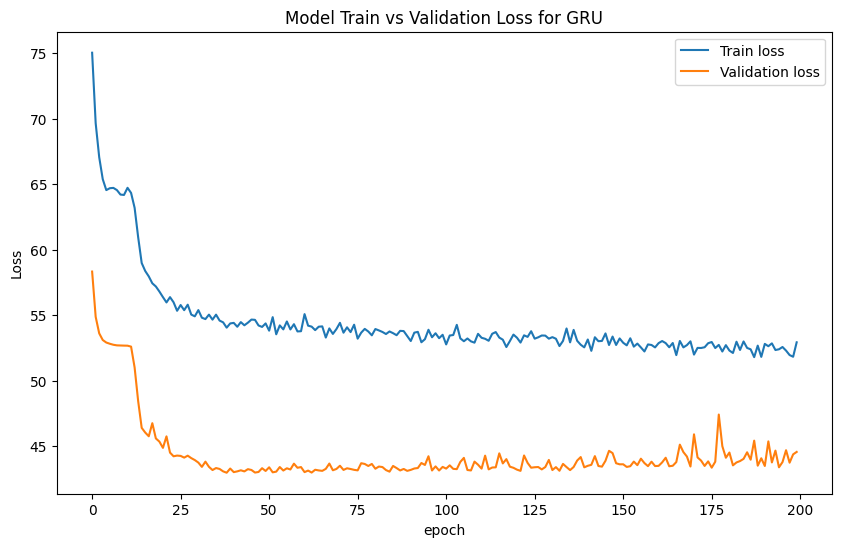

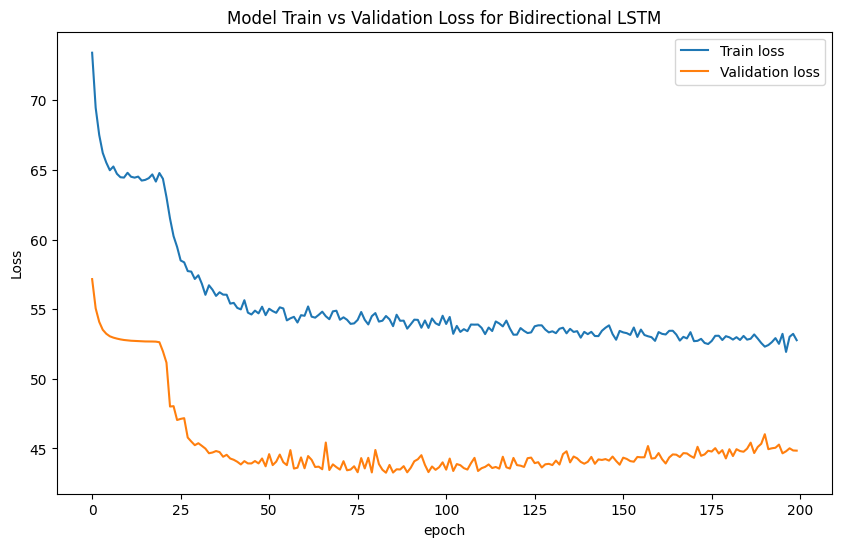

In [11]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')



In [12]:
def prediction(model):
    return model.predict(X_test)
    #prediction = scaler.inverse_transform(prediction)
    
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)


print("GRU",prediction_gru)
print("BILSTM", prediction_bilstm)




3/3 [==============================] - 1s 2ms/step
GRU [[ 95.38852  ]
 [ 48.05648  ]
 [ 14.004386 ]
 [  9.962067 ]
 [  8.364355 ]
 [  8.40479  ]
 [  9.68666  ]
 [ 17.616098 ]
 [ 83.673035 ]
 [126.062454 ]
 [136.55058  ]
 [135.75053  ]
 [ 93.445114 ]
 [ 58.419106 ]
 [ 30.518768 ]
 [ 11.214944 ]
 [ 10.392397 ]
 [  9.225402 ]
 [  9.325641 ]
 [ 21.263102 ]
 [ 49.44574  ]
 [ 66.80209  ]
 [ 57.187572 ]
 [ 53.23564  ]
 [ 37.93792  ]
 [ 20.848186 ]
 [ 10.2070055]
 [  7.947385 ]
 [  7.4747744]
 [  7.866888 ]
 [  9.524116 ]
 [ 19.1412   ]
 [ 36.95406  ]
 [ 75.910385 ]
 [ 76.064186 ]
 [ 93.19142  ]
 [ 81.43678  ]
 [ 50.45589  ]
 [ 33.023354 ]
 [ 14.63102  ]
 [  7.2068415]
 [  7.915412 ]
 [  9.223502 ]
 [ 14.371086 ]
 [ 30.033867 ]
 [101.86838  ]
 [140.40788  ]
 [142.89078  ]
 [131.00362  ]
 [ 87.39513  ]
 [ 42.607674 ]
 [ 13.227848 ]
 [  9.396637 ]
 [  8.648883 ]
 [  9.616563 ]
 [ 17.53733  ]
 [ 47.51679  ]
 [ 93.424866 ]
 [ 74.67882  ]
 [ 65.30983  ]
 [ 40.550148 ]
 [ 24.859756 ]
 [ 15.982561 ]


In [24]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

print(prediction_gru.shape)
prediction_gru = prediction_gru.flatten()
prediction_bilstm = prediction_bilstm.flatten()
evaluate_prediction(prediction_gru, test_y[1:len(test_y) - 4], 'GRU')
evaluate_prediction(prediction_bilstm, test_y[1:len(test_y) - 4], 'Bidirectiona LSTM')

(91,)
GRU:
Mean Absolute Error: 49.2737
Root Mean Square Error: 78.5163

Bidirectiona LSTM:
Mean Absolute Error: 49.9305
Root Mean Square Error: 75.9858



In [25]:
obtainedResult = np.array([])
actualResult = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_gru) or a > len(prediction_gru)):
        break
    temp1 = prediction_gru[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResult = np.concatenate((obtainedResult, temp1))
    actualResult = np.concatenate((actualResult, temp2))
    


In [26]:
evaluate_prediction(obtainedResult, actualResult, 'Winter Range GRU')

Winter Range GRU:
Mean Absolute Error: 64.2292
Root Mean Square Error: 89.8164



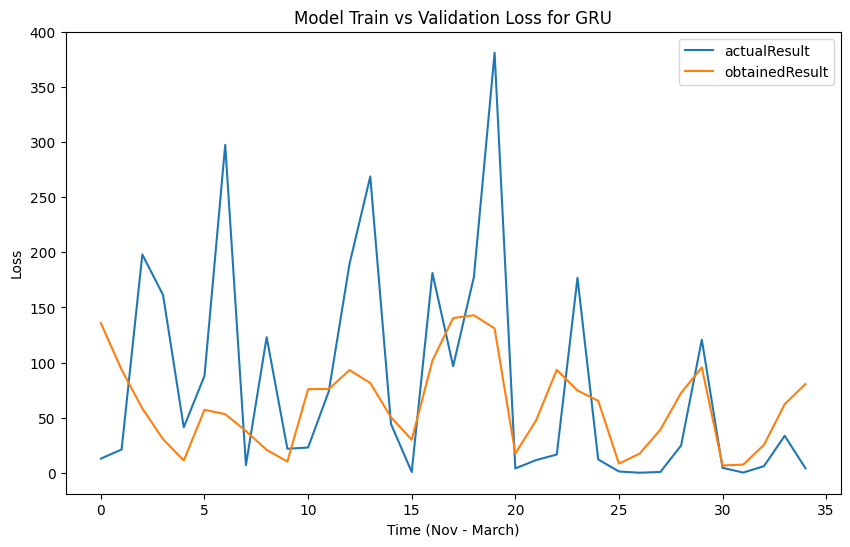

In [27]:
plt.figure(figsize = (10, 6))
plt.plot(actualResult)
plt.plot(obtainedResult)
plt.title('Model Train vs Validation Loss for GRU' )
plt.ylabel('Loss')
plt.xlabel('Time (Nov - March)')
plt.legend(['actualResult', 'obtainedResult'], loc='upper right')

In [28]:
obtainedResult = np.array([])
actualResult = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_bilstm) or a > len(prediction_bilstm)):
        break
    temp1 = prediction_gru[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResult = np.concatenate((obtainedResult, temp1))
    actualResult = np.concatenate((actualResult, temp2))

In [29]:
evaluate_prediction(obtainedResult, actualResult, 'Winter Range LSTM')

Winter Range LSTM:
Mean Absolute Error: 64.2292
Root Mean Square Error: 89.8164



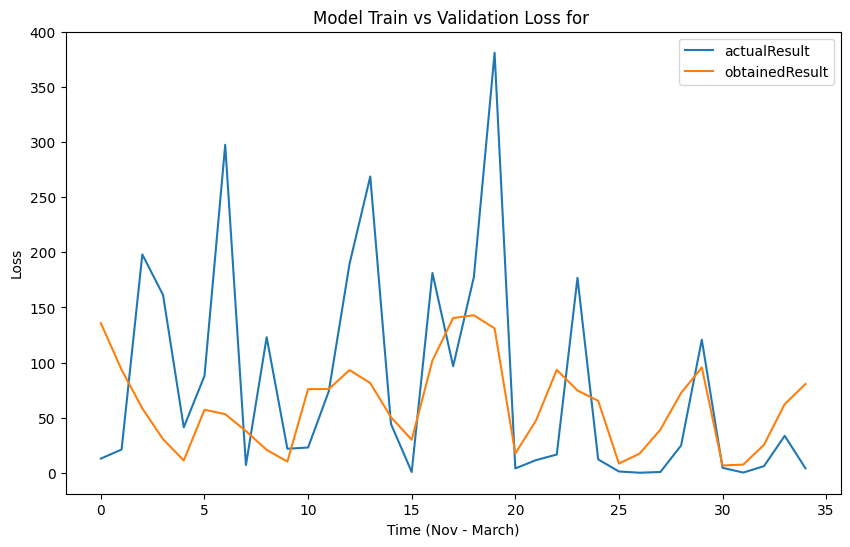

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(actualResult)
plt.plot(obtainedResult)
plt.title('Model Train vs Validation Loss for LSTM' )
plt.ylabel('Loss')
plt.xlabel('Time (Nov - March)')
plt.legend(['actualResult', 'obtainedResult'], loc='upper right')

In [30]:
for index,data in enumerate(obtainedResult):
    print(obtainedResult[index], actualResult[index])

135.7505340576172 12.9292
93.44511413574219 21.1996
58.419105529785156 198.0503
30.518768310546875 161.3026
11.214943885803223 41.2507
57.18757247924805 87.9625
53.23564147949219 297.4748
37.93791961669922 7.0892
20.848186492919922 123.0254
10.207005500793457 21.8603
75.91038513183594 22.9831
76.0641860961914 74.0655
93.19142150878906 189.5778
81.43678283691406 268.7216
50.45589065551758 44.3011
30.03386688232422 0.7685
101.86837768554688 181.2137
140.4078826904297 96.6702
142.89077758789062 177.6215
131.0036163330078 380.962
17.537330627441406 4.0216
47.516788482666016 11.5704
93.42486572265625 16.6042
74.67881774902344 176.8425
65.30982971191406 12.1807
8.399642944335938 1.2335
17.483972549438477 0.1221
39.11314010620117 0.7819
72.47772216796875 24.802
95.62403869628906 120.7473
6.715871810913086 4.5853
7.4697065353393555 0.2598
25.451257705688477 6.0749
62.31027603149414 33.5986
80.53221130371094 4.1724
